RUNNING SLSQP WITH EQUALITY (color axis) + BALL CONSTRAINT...
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.8107219352213688
            Iterations: 18
            Function evaluations: 1819
            Gradient evaluations: 18
Optimization done. success = True
Final objective: -0.8107219352213688
Initial color-axis norm = 6.4176
Final color-axis norm   = 6.4176 (difference: 5.3054e-08)
Angle pre-mod = 36.255 deg
Angle post-mod = 25.789 deg
Angle improvement = 10.466 deg


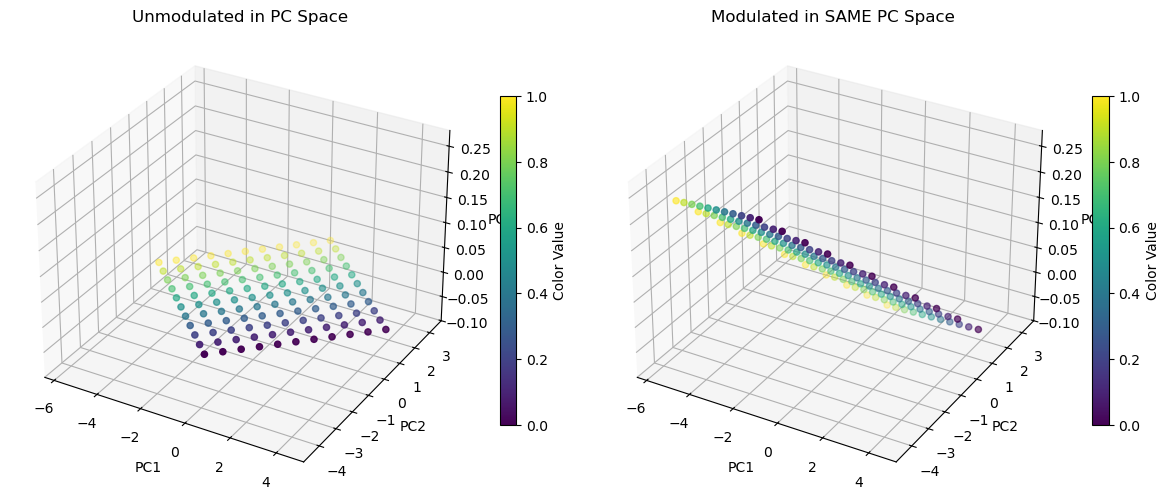

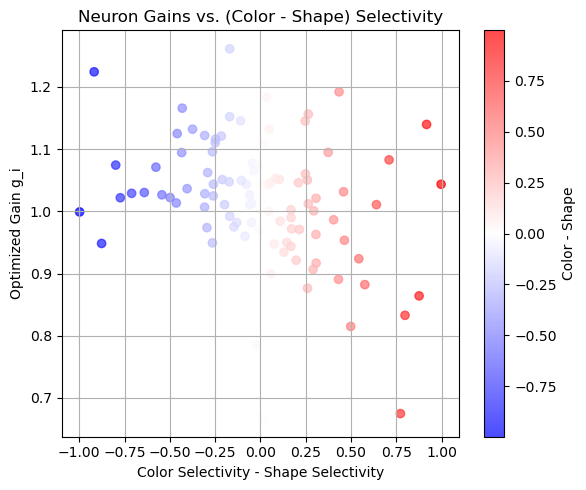

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.optimize import minimize

np.random.seed(15)

N = 100
K = 2  # shape=0, color=1
desired_radius = 0.9
p_high = 0.2
p_low  = 0.2

# -------------------------------------------------
# 1) Initialization
# -------------------------------------------------
def initialize_selectivity_matrix(N, K):
    """
    Half are shape-based, half are color-based, with a random distribution.
    """
    S = np.zeros((N, K))
    halfN = N // 2

    # For the first half: shape dimension random, then color is 0.5 - shape/2
    S[:halfN, 0] = np.random.rand(halfN)
    S[:halfN, 1] = 0.5 - S[:halfN, 0] / 2
    neg_idx = (S[:halfN, 0] - S[:halfN, 1]) < 0
    S[:halfN, 0][neg_idx] = np.random.uniform(0, 0.5, size=np.sum(neg_idx))

    # The second half is the "complementary" assignment
    S[halfN:, 1] = S[:halfN, 0]
    S[halfN:, 0] = S[:halfN, 1]

    return S

def initialize_W_F(S, shape_scale=1.0, color_scale=1.0):
    """
    Scale shape vs. color input separately, then normalize each neuron’s feedforward.
    """
    W_F = np.zeros_like(S)
    for i in range(S.shape[0]):
        s_val = shape_scale * S[i, 0]
        c_val = color_scale * S[i, 1]
        r = s_val + c_val
        if r > 0:
            W_F[i, 0] = s_val / r
            W_F[i, 1] = c_val / r
        else:
            W_F[i] = [0, 0]
    return W_F

def initialize_W_R(N, p_high, p_low, S, WR_tuned=False, desired_radius=0.9):
    """
    Build a recurrent matrix with *symmetric* blocks, optionally enforce row-sums = 0,
    optionally do distance-based scaling, and then fix the spectral radius.
    """
    halfN = N // 2
    W_R = np.zeros((N, N))

    # --- shape–shape block ---
    rand_ss = np.random.rand(halfN, halfN)
    mask_ss = rand_ss < p_high
    block_ss = np.zeros((halfN, halfN))
    block_ss[mask_ss] = np.random.rand(np.sum(mask_ss)) * 0.1

    # Copy shape–shape block onto color–color block
    W_R[:halfN, :halfN] = block_ss
    W_R[halfN:, halfN:] = block_ss

    # --- shape->color block ---
    rand_sc = np.random.rand(halfN, halfN)
    mask_sc = rand_sc < p_low
    block_sc = np.zeros((halfN, halfN))
    block_sc[mask_sc] = np.random.rand(np.sum(mask_sc)) * 0.1

    # Copy shape->color block onto color->shape block
    W_R[:halfN, halfN:] = block_sc
    W_R[halfN:, :halfN] = block_sc

    # Zero out self-connections
    np.fill_diagonal(W_R, 0)

    # Enforce row-sums = 0
    for i in range(N):
        row_sum = np.sum(W_R[i, :])
        W_R[i, :] -= row_sum / N
    np.fill_diagonal(W_R, 0)

    # Optional distance-based tuning
    if WR_tuned:
        thresh = 0.2
        for i in range(N):
            for j in range(N):
                if i != j:
                    d = np.linalg.norm(S[i] - S[j])
                    if d < thresh:
                        W_R[i, j] *= (2.0 - d / thresh)
        np.fill_diagonal(W_R, 0)

    # Fix spectral radius
    eivals = np.linalg.eigvals(W_R)
    max_ev = np.max(np.abs(eivals))
    if max_ev > 0:
        W_R *= (desired_radius / max_ev)

    return W_R

# -------------------------------------------------
# 2) Response Computations
# -------------------------------------------------
def compute_response(W_R, W_F, shape_val, color_val, g_vector=None):
    """
    Returns steady-state response for a single (shape_val, color_val).
    """
    I = np.eye(W_R.shape[0])
    if g_vector is None:
        inv_mat = np.linalg.inv(I - W_R)
        WF_eff = W_F
    else:
        G = np.diag(g_vector)
        inv_mat = np.linalg.inv(I - G @ W_R)
        WF_eff = G @ W_F

    F = np.array([shape_val, color_val])
    return inv_mat @ (WF_eff @ F)

def compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=None):
    """
    Returns a [num_shape * num_color, N] array of responses
    by scanning over shape_vals x color_vals.
    """
    responses = []
    for s in shape_vals:
        for c in color_vals:
            resp = compute_response(W_R, W_F, s, c, g_vector)
            responses.append(resp)
    return np.array(responses)

# ================================================================
# MAIN SCRIPT
# ================================================================
if __name__ == "__main__":
    # 1) Create the network
    S = initialize_selectivity_matrix(N, K)
    W_F = initialize_W_F(S)
    W_R = initialize_W_R(N, p_high, p_low, S, WR_tuned=False, desired_radius=desired_radius)

    # 2) Build a 2D grid of shape & color
    grid_points = 11
    shape_vals = np.linspace(0, 1, grid_points)
    color_vals = np.linspace(0, 1, grid_points)

    # For coloring the grid in plots, we track the color param
    color_list = []
    for s in shape_vals:
        for c in color_vals:
            color_list.append(c)
    color_list = np.array(color_list)  # shape [grid_points^2,]

    # 2.1) Compute unmodulated responses over the grid
    responses_grid_unmod = compute_grid_responses(
        W_R, W_F, shape_vals, color_vals, g_vector=None
    )
    # shape => [grid_points^2, N]

    # 2.2) PCA on unmodulated grid responses, keep 3 PCs
    pca_grid = PCA(n_components=3)
    pca_grid.fit(responses_grid_unmod)  # shape = [grid_points^2, N]
    pc_basis = pca_grid.components_  # shape [3, N]

    # We'll define v1 as the first PC (normalized)
    v1 = pc_basis[0]
    v1 /= np.linalg.norm(v1)

    # 3) For the color-axis alignment, pick shape=0.3
    shape_for_color_line = 0.3

    def color_axis_direction(g):
        """
        For a given g-vector, define color-axis as difference between
        response at color=1.0 and color=0.0 for shape=0.3.
        """
        resp_c0 = compute_response(W_R, W_F, shape_for_color_line, 0.0, g)
        resp_c1 = compute_response(W_R, W_F, shape_for_color_line, 1.0, g)
        return resp_c1 - resp_c0

    # 3.1) Compute unmodulated color axis (for norm reference):
    init_g = np.ones(N)
    d_unmod = color_axis_direction(init_g)
    norm_unmod_sq = np.linalg.norm(d_unmod)**2

    # 4) Objective: maximize cos^2 w.r.t. v1 => minimize negative cos^2
    def alignment_objective_angle_only(g):
        d_col = color_axis_direction(g)
        dot_val = np.dot(v1, d_col)
        denom = np.linalg.norm(d_col) * np.linalg.norm(v1)
        if denom < 1e-15:
            return 0.0  # degenerate
        cos_val = dot_val / denom
        # We want to maximize cos^2 => minimize the negative
        return -(cos_val**2)

    # 4.1) Exact equality constraint: keep ||d_col||^2 = ||d_unmod||^2
    def color_axis_norm_constraint(g):
        d_col = color_axis_direction(g)
        return np.linalg.norm(d_col)**2 - norm_unmod_sq

    # ------------------------------------------------------------------
    # NEW: Replace the old box [L, U] with a ball constraint:
    #      ||g - 1|| <= R
    # Choose R = 0.2 * sqrt(N) to match the outer corners of [0.8, 1.2].
    # You can pick any radius you like.
    # ------------------------------------------------------------------
    R = 0.1 * np.sqrt(N)
    def ball_constraint(g):
        return R - np.linalg.norm(g - np.ones(N))

    # We pass two constraints to SLSQP:
    #   (1) color_axis_norm_constraint (type='eq')
    #   (2) ball_constraint (type='ineq')
    constraint_eq = {
        'type': 'eq',
        'fun': color_axis_norm_constraint
    }
    constraint_ball = {
        'type': 'ineq',
        'fun': ball_constraint
    }

    # We no longer use Bounds(...) -- we only have the ball constraint
    print("RUNNING SLSQP WITH EQUALITY (color axis) + BALL CONSTRAINT...")
    res = minimize(
        fun=alignment_objective_angle_only,
        x0=init_g,
        method='SLSQP',
        constraints=[constraint_eq, constraint_ball],
        options={'maxiter': 300, 'disp': True}
    )

    g_opt = res.x
    print("Optimization done. success =", res.success)
    print("Final objective:", res.fun)

    # 5.1) Compare angles pre vs. post
    def angle_with_v1(d_vec):
        dot_v = np.dot(v1, d_vec)
        denom = np.linalg.norm(v1)*np.linalg.norm(d_vec)
        if denom < 1e-15:
            return np.nan
        val = dot_v / denom
        val = np.clip(val, -1, 1)
        angle_deg = np.degrees(np.arccos(val))
        # We'll consider 0 deg vs. 180 deg the same "axis" => pick smaller angle
        return min(angle_deg, 180.0 - angle_deg)

    d_mod = color_axis_direction(g_opt)
    angle_pre = angle_with_v1(d_unmod)
    angle_post = angle_with_v1(d_mod)

    # Check final norm
    final_norm = np.linalg.norm(d_mod)
    init_norm = np.sqrt(norm_unmod_sq)
    print(f"Initial color-axis norm = {init_norm:.4f}")
    print(f"Final color-axis norm   = {final_norm:.4f} (difference: {final_norm - init_norm:.4e})")

    print(f"Angle pre-mod = {angle_pre:.3f} deg")
    print(f"Angle post-mod = {angle_post:.3f} deg")
    print(f"Angle improvement = {angle_pre - angle_post:.3f} deg")

    # ---------------------------------------------------------
    # 6) Visualization
    # ---------------------------------------------------------

    # 6.1) 3D scatter: unmodulated vs modulated in the same PC space
    responses_grid_mod = compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=g_opt)
    proj_unmod = pca_grid.transform(responses_grid_unmod)  # shape [grid_points^2, 3]
    proj_mod = pca_grid.transform(responses_grid_mod)      # shape [grid_points^2, 3]

    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title("Unmodulated in PC Space")
    sc1 = ax1.scatter(proj_unmod[:,0], proj_unmod[:,1], proj_unmod[:,2],
                      c=color_list, cmap='viridis', s=20)
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.set_zlabel("PC3")

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title("Modulated in SAME PC Space")
    sc2 = ax2.scatter(proj_mod[:,0], proj_mod[:,1], proj_mod[:,2],
                      c=color_list, cmap='viridis', s=20)
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")
    ax2.set_zlabel("PC3")

    x_min = min(proj_unmod[:,0].min(), proj_mod[:,0].min())
    x_max = max(proj_unmod[:,0].max(), proj_mod[:,0].max())
    y_min = min(proj_unmod[:,1].min(), proj_mod[:,1].min())
    y_max = max(proj_unmod[:,1].max(), proj_mod[:,1].max())
    z_min = min(proj_unmod[:,2].min(), proj_mod[:,2].min())
    z_max = max(proj_unmod[:,2].max(), proj_mod[:,2].max())
    for ax in [ax1, ax2]:
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        ax.set_zlim([z_min, z_max])

    cb1 = plt.colorbar(sc1, ax=ax1, shrink=0.7)
    cb1.set_label("Color Value")
    cb2 = plt.colorbar(sc2, ax=ax2, shrink=0.7)
    cb2.set_label("Color Value")

    plt.tight_layout()
    plt.show()

    # 6.2) Scatter: (color_selectivity - shape_selectivity) vs. g_opt
    color_diff = S[:,1] - S[:,0]

    fig2 = plt.figure(figsize=(6,5))
    plt.scatter(color_diff, g_opt, alpha=0.7, c=color_diff, cmap='bwr')
    plt.xlabel("Color Selectivity - Shape Selectivity")
    plt.ylabel("Optimized Gain g_i")
    plt.title("Neuron Gains vs. (Color - Shape) Selectivity")
    cb = plt.colorbar()
    cb.set_label("Color - Shape")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [2]:
# Suppose your script has already computed:
#   d_unmod = color_axis_direction(init_g)
#   d_mod   = color_axis_direction(g_opt)
#   pca_grid = PCA(...) which was fit on responses_grid_unmod

# 1) Length of color-axis
length_unmod = np.linalg.norm(d_unmod)
length_mod   = np.linalg.norm(d_mod)

# 2) Projection onto PC1
#    First, define v1 = the first principal component. We'll normalize it.
v1 = pca_grid.components_[0]
v1 /= np.linalg.norm(v1)

proj_unmod_v1 = np.dot(d_unmod, v1)
proj_mod_v1   = np.dot(d_mod,   v1)

# Print everything
print("=== COLOR AXIS LENGTHS ===")
print(f"Unmodulated color-axis length: {length_unmod:.4f}")
print(f"Modulated   color-axis length: {length_mod:.4f}")
print()

print("=== PROJECTION ONTO PC1 ===")
print(f"Unmodulated axis projection on PC1: {proj_unmod_v1:.4f}")
print(f"Modulated   axis projection on PC1: {proj_mod_v1:.4f}")

=== COLOR AXIS LENGTHS ===
Unmodulated color-axis length: 6.4176
Modulated   color-axis length: 6.4176

=== PROJECTION ONTO PC1 ===
Unmodulated axis projection on PC1: -5.1751
Modulated   axis projection on PC1: -5.7784


In [13]:
import numpy as np

def simulate_decoding_accuracy(pc1_range, sigma=0.3, n_colors=100, n_samples=10000):
    """
    Simulate decoding accuracy when a linear decoder only has access to PC1.
    
    Args:
      pc1_range (float): The total PC1 difference between color=0 and color=1.
      sigma (float)    : Standard deviation of additive Gaussian noise.
      n_colors (int)   : Number of discrete color levels in [0..1).
      n_samples (int)  : Number of noise samples per color level to test.
    
    Returns:
      accuracy (float) : Average fraction of correct classifications.
    """
    step = pc1_range / (n_colors - 1)  # PC1 increment per color step
    correct_count = 0
    total_count = n_colors * n_samples

    for true_idx in range(n_colors):
        # Mean PC1 value for this color index:
        mean_pc1 = true_idx * step
        
        # Generate noisy samples for this color:
        noisy_samples = mean_pc1 + np.random.normal(0.0, sigma, size=n_samples)
        
        # Decode by rounding to nearest index in 0..(n_colors-1):
        decoded_idx = np.round(noisy_samples / step).astype(int)
        decoded_idx = np.clip(decoded_idx, 0, n_colors - 1)
        
        # Count how many samples are correct
        correct_count += np.sum(decoded_idx == true_idx)
    
    accuracy = correct_count / total_count
    return accuracy

if __name__ == "__main__":

    # From your data:
    pc1_unmod = 5.1751   # Unmodulated color-axis projection for color=1
    pc1_mod   = 5.7784   # Modulated   color-axis projection for color=1

    # Noise level:
    sigma_noise = 0.02

    # Simulation parameters:
    n_colors = 100
    n_samples_per_color = 10000

    # Run simulation for unmodulated scenario:
    acc_unmod = simulate_decoding_accuracy(
        pc1_range=pc1_unmod,
        sigma=sigma_noise,
        n_colors=n_colors,
        n_samples=n_samples_per_color
    )

    # Run simulation for modulated scenario:
    acc_mod = simulate_decoding_accuracy(
        pc1_range=pc1_mod,
        sigma=sigma_noise,
        n_colors=n_colors,
        n_samples=n_samples_per_color
    )

    print("=== Simulation Results ===")
    print(f"Unmodulated PC1 range = {pc1_unmod:.4f}")
    print(f"Modulated   PC1 range = {pc1_mod:.4f}")
    print(f"Noise sigma = {sigma_noise:.2f}")
    print(f"Decoding accuracy (unmod) = {acc_unmod*100:.2f}%")
    print(f"Decoding accuracy (mod)   = {acc_mod*100:.2f}%")


=== Simulation Results ===
Unmodulated PC1 range = 5.1751
Modulated   PC1 range = 5.7784
Noise sigma = 0.02
Decoding accuracy (unmod) = 81.02%
Decoding accuracy (mod)   = 85.67%
